# CS542 - Class Challenge - fine-grained classification of plants:

Our class challenge will consists of two tasks addressing an image recognition task where our dataset contains about 1K categories of plants with only about 250,000 images.  There will be two parts to this task:

1. Image classification. Imagine we have cateloged all the plants we care to identify, now we just need to create a classifier for them! Use your skills from the supervised learning sections of this course to try to address this problem.

2. Semi-Supervised/Few-Shot Learning.  Unfortunately, we missed some important plants we want to classify!  We do have some images we think contain the plant, but we have only have a few labels.  Our new goal is to develop an AI model that can learn from just these labeled examples.

Each student must submit a model on both tasks.  Students in the top 3 on each task will get 5% extra credit on this assignment.

This notebook is associated with the second task (semi-supervised).


# Dataset
The dataset is downloaded on scc in the address: "/projectnb2/cs542-bap/classChallenge/data". You can find the python version of this notebook there as well or you could just type "jupyter nbconvert --to script baselineModel_task2.ipynb" and it will output "baselineModel_task2.py". You should be able to run "baselineModel_task2.py" on scc by simply typing "python baselineModel_task2.py"

Please don't try to change or delete the dataset.

# Evaluation:
You will compete with each other over your performance on the dedicated test set. The performance measure is classification accuracy, i.e: if the true class is your top predictions. 

# Baseline:
The following code is a baseline which you can use and improve to come up with your model for this task

# Suggestion
One simple suggestion would be to use a pretrained model on imagenet and finetune it on this data similar to this [link](https://keras.io/api/applications/)
Also you should likely train more than 2 epochs.

## Import TensorFlow and other libraries

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [14]:
print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(os.getenv("CUDA_VISIBLE_DEVICES"))
tf.config.set_soft_device_placement(True)
def get_n_cores():
  nslots = os.getenv('NSLOTS')
  if nslots is not None:
    return int(nslots)
  raise ValueError('Environment variable NSLOTS is not defined.')
print("NUM CORES: ", get_n_cores())
tf.config.threading.set_intra_op_parallelism_threads(get_n_cores()-1)
tf.config.threading.set_inter_op_parallelism_threads(1)

2.3.1
Num GPUs Available:  1
3
NUM CORES:  4


# Create a dataset

In [15]:
data_dir = '/projectnb2/cs542-bap/class_challenge/'

train_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'train_held_out_labeled.txt'))
train_unlabeled_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'train_held_out.txt'))
val_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'val_held_out.txt'))
test_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'test_held_out.txt'))

with open(os.path.join(data_dir, 'classes_held_out.txt'), 'r') as f:
  class_names = [c.strip() for c in f.readlines()]

num_classes = len(class_names)
print(num_classes)

20


## Write a short function that converts a file path to an (img, label) pair:

In [16]:
def decode_img(img, crop_size=224):
  img = tf.io.read_file(img)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [crop_size, crop_size])

def get_label(label):
  # find teh matching label
  one_hot = tf.where(tf.equal(label, class_names))
  # Integer encode the label
  return tf.reduce_min(one_hot)

def process_path(file_path):
  # should have two parts
  file_path = tf.strings.split(file_path)
  # second part has the class index
  label = get_label(file_path[1])
  # load the raw data from the file
  img = decode_img(tf.strings.join([data_dir, 'images/', file_path[0], '.jpg']))
  return img, label

def process_path_unlabeled(file_path):
  # load the raw data from the file
  img = decode_img(tf.strings.join([data_dir, 'images/', file_path, '.jpg']))
  #WE are using this method for unlabeled data, so we will manually return -1 as a label for scikit clustering
  return img, tf.cast(-1., tf.int64)

def process_path_test(file_path):
  # load the raw data from the file
  img = decode_img(tf.strings.join([data_dir, 'images/', file_path, '.jpg']))
  return img, file_path

# Finish setting up data

In [17]:
batch_size = 25

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#train_unlabeled_ds = train_unlabeled_ds.map(process_path_unlabeled, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path_test, num_parallel_calls=AUTOTUNE)

#Concatenate labeled and unlabeled for one training dataset
####train_ds = train_ds.concatenate(train_unlabeled_ds)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## KNN to label unlabled data points, skip

In [18]:
#Adapted from scikit learn docs
'''
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]

cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

# #############################################################################
# Calculate uncertainty values for each transduced distribution
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

# #############################################################################
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

# #############################################################################
# Plot
f = plt.figure(figsize=(7, 5))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index]

    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('predict: %i\ntrue: %i' % (
        lp_model.transduction_[image_index], y[image_index]))

f.suptitle('Learning with small amount of labeled data')
plt.show()

'''

'\npredicted_labels = lp_model.transduction_[unlabeled_set]\ntrue_labels = y[unlabeled_set]\n\ncm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)\n\nprint("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %\n      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))\n\nprint(classification_report(true_labels, predicted_labels))\n\nprint("Confusion matrix")\nprint(cm)\n\n# #############################################################################\n# Calculate uncertainty values for each transduced distribution\npred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)\n\n# #############################################################################\n# Pick the top 10 most uncertain labels\nuncertainty_index = np.argsort(pred_entropies)[-10:]\n\n# #############################################################################\n# Plot\nf = plt.figure(figsize=(7, 5))\nfor index, image_index in enumerat

# Offline Image Augmentation

In [19]:
def augmentFlipUD(img, label):
    return tf.image.flip_up_down(img), label

def augmentFlipLR(img, label):
    return tf.image.flip_left_right(img), label

def augmentRotate(img, label):
    if np.random.random() < .5:
        return tf.image.rot90(img, k=1), label
    else:
        return tf.image.rot90(img, k=3), label
    
#Let's augment and grow our training set 4x

tdsAugment = train_ds.map(augmentFlipUD, num_parallel_calls=AUTOTUNE)
tdsAugment = tdsAugment.concatenate(train_ds.map(augmentFlipLR, num_parallel_calls=AUTOTUNE))
tdsAugment = tdsAugment.concatenate(train_ds.map(augmentRotate, num_parallel_calls=AUTOTUNE))

train_ds = train_ds.concatenate(tdsAugment)

## Data loader hyper-parameters for performance!

In [20]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
#train_unlabeled_ds = configure_for_performance(train_unlabeled_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

## Transfer Learning from Task 1 model

In [21]:
#Load and use model from task 1
task1_model = keras.models.load_model('baselineAugmented.hdf5')

#Set base to untrainable
task1_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = task1_model(inputs, training=False)
outputs = keras.layers.Dense(20)(x)
model = keras.Model(inputs, outputs)


## The usual loss function

In [22]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])

## Training

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:
checkpoint = ModelCheckpoint("task2.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq='epoch')

es = EarlyStopping(monitor='val_loss', min_delta = .1, patience=2)

first_iter_history = model.fit(train_ds,validation_data=val_ds,epochs=40,shuffle=True, callbacks=[checkpoint, es])

Epoch 1/40
     16/Unknown - 0s 10ms/step - loss: 5.3874 - accuracy: 0.0925 - sparse_top_k_categorical_accuracy: 0.2600
Epoch 00001: loss improved from inf to 5.38738, saving model to task2.hdf5
16/16 [==============================] - 13s 799ms/step - loss: 5.3874 - accuracy: 0.0925 - sparse_top_k_categorical_accuracy: 0.2600 - val_loss: 4.2679 - val_accuracy: 0.0776 - val_sparse_top_k_categorical_accuracy: 0.4323
Epoch 2/40
13/16 [=======================>......] - ETA: 0s - loss: 4.0777 - accuracy: 0.1385 - sparse_top_k_categorical_accuracy: 0.4123
Epoch 00002: loss improved from 5.38738 to 4.02875, saving model to task2.hdf5
16/16 [==============================] - 0s 30ms/step - loss: 4.0287 - accuracy: 0.1375 - sparse_top_k_categorical_accuracy: 0.4150 - val_loss: 3.4428 - val_accuracy: 0.1551 - val_sparse_top_k_categorical_accuracy: 0.5429
Epoch 3/40
13/16 [=======================>......] - ETA: 0s - loss: 3.2441 - accuracy: 0.2062 - sparse_top_k_categorical_accuracy: 0.5569
Epoc

In [25]:
print(first_iter_history.history.keys())

dict_keys(['loss', 'accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_sparse_top_k_categorical_accuracy'])


# Learning Curves

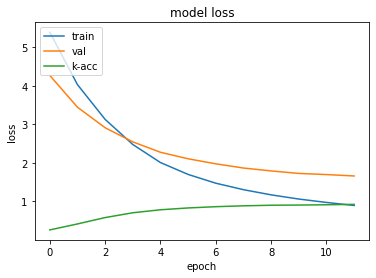

In [26]:
plt.plot(first_iter_history.history['loss'])
plt.plot(first_iter_history.history['val_loss'])
plt.plot(first_iter_history.history['sparse_top_k_categorical_accuracy'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'k-acc'], loc='upper left')
plt.show()

# Pseudo Labeling

# Output submission csv for Kaggle


In [27]:
#new_model = keras.models.load_model('baselineAugmented.hdf5')
#with open('submission_task2_2_semisupervised.csv', 'w') as f:
#new_model = keras.models.load_model('task2.hdf5')

    
with open('submission_task2_semisupervised.csv', 'w') as f:
  f.write('id,predicted\n')
  for image_batch, image_names in test_ds:
    predictions = model.predict(image_batch)
    for image_name, predictions in zip(image_names.numpy(), model.predict(image_batch)):
      inds = np.argmax(predictions)
      line = str(int(image_name)) + ',' + class_names[inds]
      f.write(line + '\n')

**Note**

Absolute path is recommended here. For example, use "/projectnb2/cs542-bap/[your directory name]/submission_task2_supervised.csv" to replace "submission_task2_supervised.csv".

Besides, you can request good resources by specify the type of gpus, such as "qsub -l gpus=1 -l gpu_type=P100 [your file name].qsub". This is helpful to avoid potential issues of GPUs, such as out of memory, etc.